In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import numpy as np
from torchvision import datasets, transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # tensor: data = batch x X y Y -> float
            # tensor: target = batch -> float
            output = model(data)
            # tensor: output = batch -> float
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [3]:
# load args and setup
import sys


def get_args():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    loaded_args = parser.parse_args()
    loaded_use_cuda = not loaded_args.no_cuda and torch.cuda.is_available()
    return loaded_args, loaded_use_cuda


if len(sys.argv) == 3:
    print("override argv")
    sys.argv = ["none"]
print("running with argv={} ----- {}".format(sys.argv, len(sys.argv)))

args, use_cuda = get_args()
torch.manual_seed(args.seed)

# Set device
device = torch.device("cuda" if use_cuda else "cpu")

# Init dataloaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


override argv
running with argv=['none'] ----- 1


In [4]:
# train net or load state

load = True
save = False
net = Net()
model = net.to(device)
if load:
    # load
    model.load_state_dict(torch.load("mnist_state"))
else:
    # train and save
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
    
    if save:
        torch.save(model.state_dict(), "mnist_state")

In [5]:
# loader for example images
show_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1, shuffle=False, **kwargs)


baseline  tensor([-0.0536], device='cuda:0')


100%|████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 212.08it/s]


baseline  tensor([-0.0536], device='cuda:0')


100%|███████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 94.12it/s]


heatmap: (28, 28)
max: 0.6851
min: -0.0071
avg: 0.0406
std: 0.0921


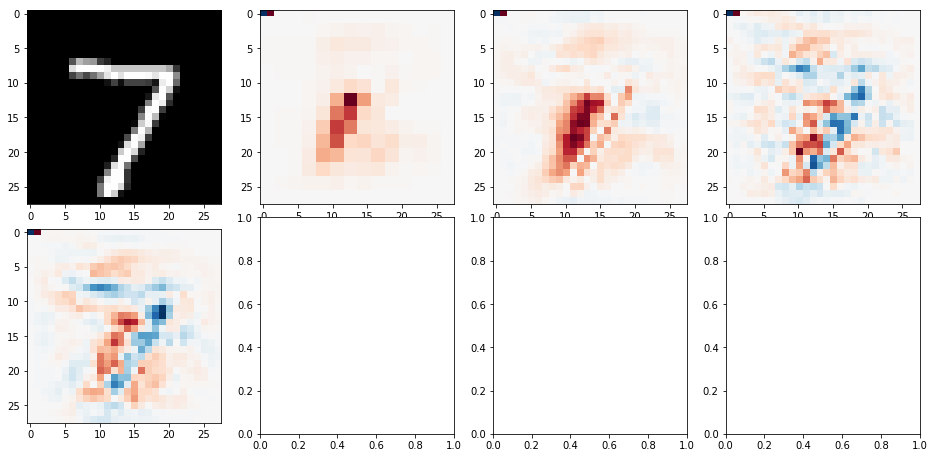

In [8]:
import attribution
import attribution.methods as am
import attribution.utils as au
import importlib

importlib.reload(attribution.methods)
importlib.reload(attribution.utils)

methods = []
methods.append(am.Occlusion(size=3, stride=2, patch_type="inv")) 
methods.append(am.Occlusion(size=1, stride=1, patch_type="inv")) 
methods.append(am.SmoothGrad(std=0)) # = gradients
methods.append(am.SmoothGrad(std=0.2))
#methods.append(am.IntegratedGradients(steps=30))
#methods.append(am.IntegratedGradients(steps=30, only_positive=True))
#methods.append(am.SmoothGrad(std=0, times_input=True))
#methods.append(am.SmoothGrad(std=0.2, times_input=True))
#methods.append(am.IntegratedGradients(steps=30, baseline=1))


for i, (img, real_label) in enumerate(show_loader):
    maps = au.compare_methods(methods, model=model, img=img.to(device))
    au.analyze_hmap(maps[0])
    if i >= 0:
        break